In [16]:
# Import External Packages
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tslearn
from tslearn.clustering import TimeSeriesKMeans

# Importing Custom Functions
import clusteringFns as clf
import plotFns as psyplt

# Setting Seed for Reproducibility
np.random.seed(2021)

curPath = os.path.abspath(os.getcwd())

In [ ]:
# In this notebook, we will format learning trajectories and transform them so that they can be clustered. We will then apply dynamic time-warping
# clustering, checking the stability of the clusters, before visualizing our results.

In [18]:
## Formatting and subsampling trajectories into a dataframe to be clustered

IDs = ('GS027', 'GS028', 'GS029', 'GS030', 'GS037', 'GS040', 'JC025', 'JC028', 
       'JC029', 'JC039', 'JC044', 'JC047', 'JC048', 'JC052', 'JC057', 'JC059', 
       'JC061', 'JC062', 'JC067')

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning"))

signedTraceMat, avgTraceMat = clf.generateTraceMats(IDs, dataBase)

In [19]:
## Determining which mice are in stable clusters at k = 2

# Converting traces to time series dataset
X = avgTraceMat
X = tslearn.utils.to_time_series_dataset(X)

seed = 1008
met = "dtw"
clusterDat = np.zeros((19,19))

# Running clustering algorithm 100 times, and keeping track of how regularly mice are co-clustered

nr = 100
ks = np.ones((1,nr)) + 1
ks = np.squeeze(ks)

for i, k in enumerate(ks):

    km = TimeSeriesKMeans(n_clusters = 2, metric=met, max_iter=50, random_state=seed + i)
    km.fit(X)
    x_pred = km.predict(X)

    for ix in range(0,19):
        for iy in range(0,19):
            if x_pred[ix] == x_pred[iy]:
                clusterDat[ix,iy] += 1

clusterDat = clusterDat/nr
clusterDat = pd.DataFrame(clusterDat, columns=IDs, index = IDs)

d = [0,0,0]

for n in range(0,19):
    temp = np.array(clusterDat.iloc[n,:])
    temp = np.delete(temp,[n,])
    
    h = np.histogram(temp,[0,0.3, 0.7, 1])
    d = np.vstack([d,h[0]])

d = d[1:]
d = pd.DataFrame(d, columns = ['Not In Same Cluster', 'Inconsistent', 'In Same Cluster'], index = IDs)

# Defining clusters from co-clustering matrix

d['Cluster'] = 2
d.loc[clusterDat['GS027'] > 0.7, 'Cluster'] = 0
d.loc[clusterDat['GS027'] < 0.3, 'Cluster'] = 1

print(d)

       Not In Same Cluster  Inconsistent  In Same Cluster  Cluster
GS027                    8             2                8        0
GS028                    8             2                8        0
GS029                    8             2                8        0
GS030                    8             2                8        0
GS037                    9             2                7        1
GS040                    9             2                7        1
JC025                    8             2                8        0
JC028                    9             2                7        1
JC029                    9             2                7        1
JC039                    9             2                7        1
JC044                    8             2                8        0
JC047                    9             2                7        1
JC048                    8             2                8        0
JC052                    0            17                1     

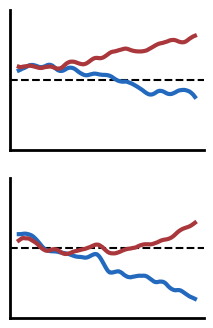

In [21]:
# We can see that 17 of the 19 mice are consistently clustered, while 2 are not. Now, we can visualize 
# the average conditional accuracy traces of each cluster.

Xp = signedTraceMat
Xp = np.array(Xp)

x_pred = d['Cluster']

fig, axs = psyplt.plotClustersVert(Xp, x_pred, nPoints = 100)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

for ax in axs:

    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(2)
    ax.set_ylim(-0.05,1.05)
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

fig.set_size_inches(2.5,4)

plt.show()

In [ ]:
# We can see that the clusters vary based on their initial dynamics (maintaining intial magnitude and direction of choice bias vs switching choice bias side).